In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualizer.main import Visualizer

# Rysowanie triangulacji

In [6]:
def convert_to_lines(points):
    lines = []
    for p in range(len(points)-1):
        lines.append((points[p], points[p+1]))
    lines.append((points[-1], points[0]))
    return lines

def draw_triangulation(points, triangulation):
    vis = Visualizer()
    polygon = convert_to_lines(points)
    vis.add_line_segment(polygon)
    for triangle in triangulation:
        add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
        lines = convert_to_lines(add)
        vis.add_line_segment(lines)
    vis.show()

# Tworzenie wielokątów za pomocą myszki

In [ ]:
%matplotlib tk

polygon = []
is_closed = False


def onclick(event):
    x = event.xdata
    y = event.ydata
    if x is not None and y is not None:
        polygon.append((x, y))
        plt.scatter(x, y, s=20, c='b', marker='o')

def on_press(event):
    global is_closed
    if event.key == 'enter':
        plt.close()
        is_closed = True
        
fig, ax = plt.subplots()
ax.set_title('Wybierz punkty na wykresie. Gdy skończysz, wciśnij "enter".')

fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('key_press_event', on_press)


plt.xlim(-100, 100)
plt.ylim(-100, 100)


while not is_closed:
    plt.pause(0.1)

print(polygon)
%matplotlib inline

# Generowanie triangulacji

In [30]:
def calculate_determinant(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    
    return (ax - cx) * (by - cy) - (ay - cy) * (bx - cx)

def check_orientation(a, b, c):
    epsilon = 10**-17
    determinant = calculate_determinant(a, b, c)
    if determinant < -epsilon:
        ## right
        return 1
    if determinant > epsilon:
        ## left
        return -1
    ## center
    return 0

def find_lowest_point(polygon):
    lowest_point_index = 0
    for index, point in enumerate(polygon):
        if point[1] < polygon[lowest_point_index][1]:
            lowest_point_index = index
    return lowest_point_index

def find_top_point(polygon, lowest_point):
    index = lowest_point
    while True:
        next_index = (index + 1) % len(polygon)
        if polygon[next_index][1] < polygon[index][1]:
            return index
        index = next_index

def polygon_parts(polygon):
    lowest_point = find_lowest_point(polygon)
    point_on_left = [False for _ in polygon]
    top_point = find_top_point(polygon, lowest_point)
    index = top_point
    while index != lowest_point:
        point_on_left[index] = True
        index = (index + 1) % len(polygon)
    return point_on_left

def inside_polygon(index1, index2, index3, point2_on_left, polygon):
    point1 = polygon[index1]
    point2 = polygon[index2]
    point3 = polygon[index3]
    orient = check_orientation(point1, point2, point3)
    if point2_on_left:
        return orient == -1
    return orient == 1

def side_exists(index1, index2, polygon_size):
    return index1 == (index2 + 1) % polygon_size or index2 == (index1 + 1) % polygon_size

def edge_neighbours(first_edge, edges):
    neighbours = []
    for edge in edges:
        if len(set(first_edge).intersection(set(edge))) == 1:
            neighbours.append(edge)
    return neighbours

def joining_edge_found(first_edge, second_edge, edges):
    [vertex_1] = set(first_edge).difference(set(second_edge))
    [vertex_2] = set(second_edge).difference(set(first_edge))
    if vertex_2 == vertex_1:
        return False
    for edge in edges:
        if vertex_1 in edge and vertex_2 in edge:
            return True
    return False

def generate_faces(vertices, diagonals):
    edges = [d for d in diagonals]
    for i in range(len(vertices) - 1):
        edges.append([i, i+1])
    edges.append([len(vertices) - 1, 0])
    
    faces = set()
    for edge in edges:
        neighbours = edge_neighbours(edge, edges)
        for neighbour in neighbours:
            if joining_edge_found(edge, neighbour, edges):
                indices = set(edge).union(set(neighbour))
                faces.add(tuple(sorted(tuple(indices))))
    return [face for face in faces]

def triangulate(polygon):
    indexes = [i for i in range(len(polygon))]
    point_on_left = polygon_parts(polygon)
    indexes.sort(key=lambda index: polygon[index][1], reverse=True)
    
    diagonals = []
    
    stack = [indexes[0], indexes[1]]
    for index in indexes[2:]:
        if point_on_left[index] != point_on_left[stack[-1]]:
            for stack_index in stack:
                if not side_exists(stack_index, index, len(polygon)):
                    diagonals.append([stack_index, index])
            stack = [stack[-1],]
        else:
            while len(stack) > 1:
                current_vertex = stack.pop(-1) 
                if not inside_polygon(stack[-1], current_vertex, index, point_on_left[current_vertex], polygon):
                    stack.append(current_vertex)
                    break
                if not side_exists(index, stack[-1], len(polygon)):
                    diagonals.append([index, stack[-1]])
        stack.append(index)
    return generate_faces(polygon, diagonals)

# Ładowanie triangulacji z/do pliku

In [21]:
def load_from_file(filename):
    vertices = []
    triangles = []
    with open(f"triangulations/{filename}", "r") as f:
        text = f.read().strip()
    for line in text.splitlines():
        row_elements = line.split()
        try:
            if row_elements[0] == "v":
                vertices.append((float(row_elements[1]), float(row_elements[2])))
            elif row_elements[0] == "t":
                triangles.append((int(row_elements[1]), int(row_elements[2]), int(row_elements[3])))
            else:
                print("Wrong row type - it should be either 't' for triangle indices or 'v' for vertices")
                break
        except ValueError:
            print("Vertices' coordinates should be floats and triangle indices should be integers")
            break
        except IndexError:
            print("Vertex's row should contain only a single character 'v' and two float numbers separated by spaces. Triangle's row should contain character 't' and three numbers separated by spaces.")
            break
    return vertices, triangles

def save_to_file(filename, vertices, triangles):
    lines = []
    for x, y in vertices:
        lines.append(f"v {x} {y}")
    for a, b, c in triangles:
        lines.append(f"t {a} {b} {c}")
    text = "\n".join(lines)
    with open(f"triangulations/{filename}", "w") as f:
        f.write(text)

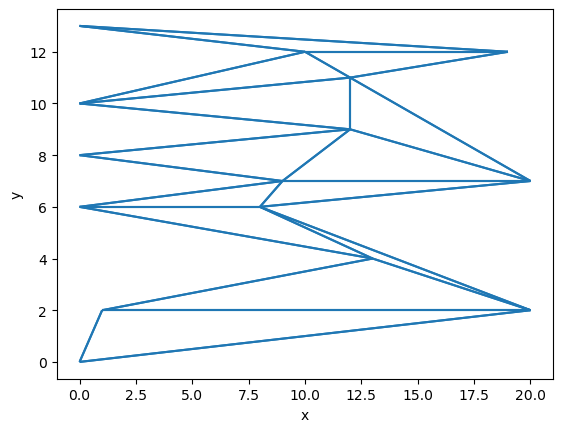

In [20]:
vis = Visualizer()
points1, triangulation1 = load_from_file("triangulations/sample_triangulation6.txt")
polygon = convert_to_lines(points1)
vis.add_line_segment(polygon)
for triangle in triangulation1:
    add = [points1[triangle[0]], points1[triangle[1]], points1[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines)
vis.show()

# Implementacja struktury Half Edge

In [23]:
class HalfEdge:
    def __init__(self, origin, face):
        self.origin = origin
        self.face = face
        self.twin = None
        self.prev = None
        self.next = None
        self.visualizer_figure = None
        
    def add_to_visualizer(self, vis, vertices):
        start = self.origin
        end = self.twin.origin
        self.visualizer_figure = vis.add_line_segment((vertices[start].coords, vertices[end].coords), color="blue")
    
    def remove_from_visualizer(self, vis):
        vis.remove_figure(self.visualizer_figure)
        self.visualizer_figure = None

class Vertex:
    def __init__(self, coords):
        self.coords = coords
        self.half_edge = None


class Face:
    def __init__(self, indices):
        self.indices = indices
        self.half_edge = None


class HalfEdgeGraph:
    
    def twin_edges(self, edge1, edge2):
        edge1.twin = edge2
        edge2.twin = edge1
    
    def connect_edges(self, edges):
        for i in range(len(edges)):
            edges[i].next = edges[(i + 1) % len(edges)]
        for i in range(len(edges)):
            edges[i].prev = edges[i - 1]
    
    def edges_overlapping(self, index1, index2, index3):
        edges = ((index1, index2), (index2, index3), (index3, index1))
        for edge in edges:
            if edge in self.edges:
                return True
        return False
    
    def connect_twins(self):
        original_keys = [key for key in self.edges.keys()]
        exterior_ends = {}
        for key in original_keys:
            reversed_key = (key[1], key[0])
            if reversed_key not in self.edges:
                exterior_edge = HalfEdge(reversed_key[0], None)
                self.edges[reversed_key] = exterior_edge
                exterior_ends[reversed_key[0]] = reversed_key[1]
            self.twin_edges(self.edges[key], self.edges[reversed_key])
        return exterior_ends
        
    def connect_cycle(self, exterior_ends):
        start = next((key for key in exterior_ends.keys()))
        cycle = [(start, exterior_ends[start]),]
        current = exterior_ends[start]
        while current != start:
            cycle.append((current, exterior_ends[current]))
            current = exterior_ends[current]
        self.connect_edges([self.edges[edge] for edge in cycle])
        
    def create_edges(self):
        for face_index, face in enumerate(self.faces):
            index1, index2, index3 = face.indices
            if not self.edges_overlapping(index1, index2, index3):
                edges_vertices = ((index1, index2), (index2, index3), (index3, index1))
            else:
                edges_vertices = ((index1, index3), (index3, index2), (index2, index1))
            edges = []
            for vertex1, vertex2 in edges_vertices:
                edge = HalfEdge(vertex1, face_index)
                edges.append(edge)
                if self.vertices[vertex1].half_edge is None:
                    self.vertices[vertex1].half_edge = edge
                if self.faces[face_index].half_edge is None:
                    self.faces[face_index].half_edge = edge
                self.edges[(vertex1, vertex2)] = edge
            self.connect_edges(edges)
        exterior_ends = self.connect_twins()
        self.connect_cycle(exterior_ends)
    
    def check_layers(self, layers, index):
        for layer in layers:
            if index in layer:
                return True
        return False
    
    def get_color(self, level):
        if level == 0:
            return "red"
        if level == 1:
            return "orange"
        if level == 2:
            return "yellow"
        return "green"        
    
    def incidental_vertices_visualize(self, vertex_index, levels, visualizer):
        layers = [{vertex_index,},]
        visualizer.add_point(self.vertices[vertex_index].coords, color=self.get_color(0))
        for i in range(1, levels + 1):
            layers.append(set())
            for index in layers[i-1]:
                start_vertex = self.vertices[index]
                start_edge = start_vertex.half_edge
                current_edge = start_edge
                while True:
                    current_edge = current_edge.prev
                    current_edge.add_to_visualizer(visualizer, self.vertices)
                    current_edge.remove_from_visualizer(visualizer)
                    if not self.check_layers(layers, current_edge.origin):
                        layers[i].add(current_edge.origin)
                        visualizer.add_point(self.vertices[current_edge.origin].coords, color=self.get_color(i))
                    current_edge = current_edge.twin
                    if current_edge is start_edge:
                        break
        return layers, visualizer
    
    def incidental_vertices(self, vertex_index, levels):
        layers = [{vertex_index,},]
        for i in range(1, levels + 1):
            layers.append(set())
            for index in layers[i-1]:
                start_vertex = self.vertices[index]
                start_edge = start_vertex.half_edge
                current_edge = start_edge
                while True:
                    current_edge = current_edge.prev
                    if not self.check_layers(layers, current_edge.origin):
                        layers[i].add(current_edge.origin)
                    current_edge = current_edge.twin
                    if current_edge is start_edge:
                        break
        return layers
    
    def incidental_triangles_visualize(self, face_index, levels, visualizer):
        layers = [{face_index,},]
        coords = [self.vertices[index].coords for index in self.faces[face_index].indices]
        visualizer.add_polygon(coords, color=self.get_color(0))
        for i in range(1, levels+1):
            layers.append(set())
            for index in layers[i-1]:
                face = self.faces[index]
                start_edge = face.half_edge
                current_edge = start_edge
                while True:
                    current_edge.add_to_visualizer(visualizer, self.vertices)
                    current_edge.remove_from_visualizer(visualizer)
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        twin_face = self.faces[twin.face]
                        coords = [self.vertices[index].coords for index in twin_face.indices]
                        visualizer.add_polygon(coords, color=self.get_color(i))
                        layers[i].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
        return layers, visualizer
    
    def incidental_triangles(self, face_index, levels):
        layers = [{face_index,},]
        for i in range(1, levels+1):
            layers.append(set())
            for index in layers[i-1]:
                face = self.faces[index]
                start_edge = face.half_edge
                current_edge = start_edge
                while True:
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        layers[i].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
        return layers
    
    def seek_vertex_visualize(self, face_index, vertex_index, visualizer):
        visualizer.add_point(self.vertices[vertex_index].coords, color="red")
        layers = [{face_index,},]
        i = 0
        while True:
            layers.append(set())
            face_found = None
            for index in layers[i]:
                face = self.faces[index]
                
                coords = [self.vertices[index].coords for index in face.indices]
                visualizer.add_polygon(coords, color="yellow")

                start_edge = face.half_edge
                current_edge = start_edge
                while True:
                    current_edge.add_to_visualizer(visualizer, self.vertices)
                    current_edge.remove_from_visualizer(visualizer)
                    
                    if current_edge.origin == vertex_index:
                        face_found = self.faces[current_edge.face]
                        coords = [self.vertices[index].coords for index in face_found.indices]
                        visualizer.add_polygon(coords, color="green")
                        break
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        layers[i+1].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
                if not layers[i+1] or face_found is not None:
                    return face_found, visualizer
            i += 1
            
    def seek_vertex(self, face_index, vertex_index):
        layers = [{face_index,},]
        i = 0
        while True:
            layers.append(set())
            face_found = None
            for index in layers[i]:
                face = self.faces[index]
                start_edge = face.half_edge
                current_edge = start_edge
                while True:  
                    if current_edge.origin == vertex_index:
                        face_found = self.faces[current_edge.face]
                        break
                    twin = current_edge.twin
                    if twin.face is not None and not self.check_layers(layers, twin.face):
                        layers[i+1].add(twin.face)
                    current_edge = current_edge.next
                    if current_edge is start_edge:
                        break
                if not layers[i+1] or face_found is not None:
                    return face_found
            i += 1

            
    def __init__(self, vertices, faces):
        self.vertices = [Vertex(v) for v in vertices]
        self.faces = [Face(f) for f in faces]
        self.edges = {}
        self.create_edges()


# Test operacji na strukturze Half Edge

In [24]:
points4, triangulation4 = load_from_file("sample_triangulation4.txt")
half_edges4 = HalfEdgeGraph(points4, triangulation4)

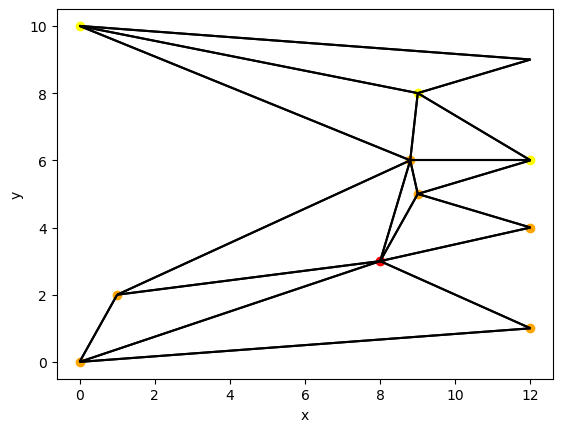

In [25]:
vis = Visualizer()
triangulation = triangulation4
points = points4
polygon = convert_to_lines(points)
vis.add_line_segment(polygon, color="black")
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines, color="black")
_, vis = half_edges4.incidental_vertices_visualize(2, 2, vis)
vis.show()

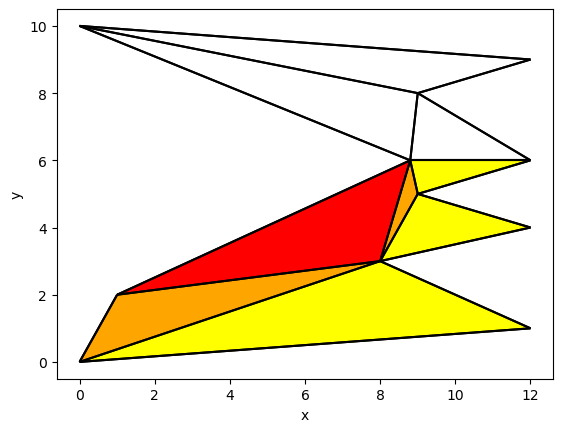

In [26]:
vis = Visualizer()
triangulation = triangulation4
points = points4
polygon = convert_to_lines(points)
vis.add_line_segment(polygon, color="black")
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines, color="black")
_, vis = half_edges4.incidental_triangles_visualize(2, 2, vis)
vis.show()

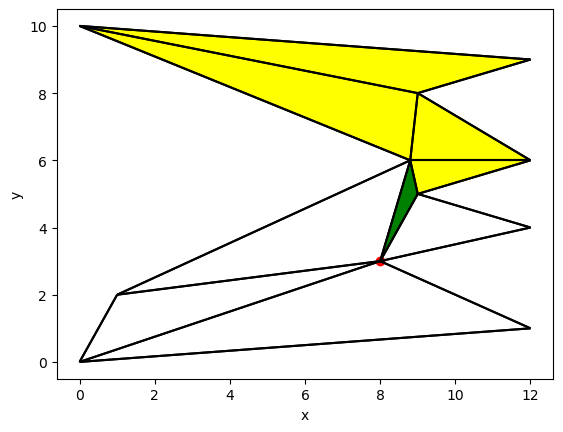

In [27]:
vis = Visualizer()
triangulation = triangulation4
points = points4
polygon = convert_to_lines(points)
vis.add_line_segment(polygon, color="black")
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines, color="black")
_, vis = half_edges4.seek_vertex_visualize(8, 2, vis)
vis.show()

# Przeszukiwanie incydentnych wierzchołków w zwykłej strukturze

Otoczenie jednowarstwowe wierzchołka 5 - [9, 4, 6]
Otoczenie dwuwarstwowe wierzchołka 5 - [2, 3, 7, 8, 10]


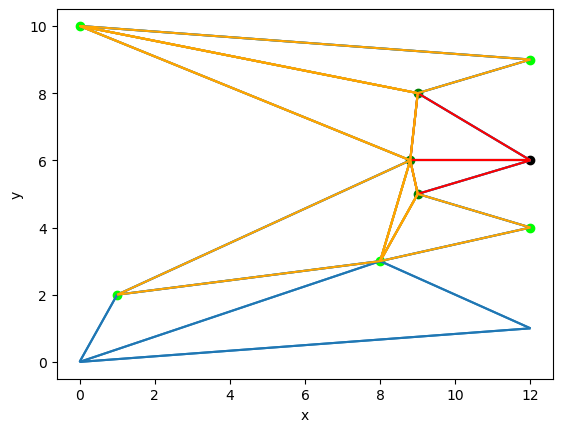

In [127]:
def find_neighbors(vertex_index, triangles):
    neighbors_one_layer = set()
    neighbors_two_layers = set()


    for triangle in triangles:
        if vertex_index in triangle:
            neighbors_one_layer.update(triangle)
            vis.add_line_segment([vertices[triangle[0]], vertices[triangle[1]]], color = 'red')
            vis.add_line_segment([vertices[triangle[0]], vertices[triangle[2]]], color = 'red')
            vis.add_line_segment([vertices[triangle[2]], vertices[triangle[1]]], color = 'red')

    neighbors_one_layer.remove(vertex_index)

    
    for neighbor in neighbors_one_layer:
        for triangle in triangles:
            if neighbor in triangle and vertex_index not in triangle:
                neighbors_two_layers.update(triangle)
                vis.add_line_segment([vertices[triangle[0]], vertices[triangle[1]]], color = 'orange')
                vis.add_line_segment([vertices[triangle[0]], vertices[triangle[2]]], color = 'orange')
                vis.add_line_segment([vertices[triangle[2]], vertices[triangle[1]]], color = 'orange')

    neighbors_two_layers -= neighbors_one_layer
    neighbors_two_layers.discard(vertex_index)

    return list(neighbors_one_layer), list(neighbors_two_layers)


vertices = points4

triangles = triangulation4

vis = Visualizer()
vis.clear()
triangulation = triangles
points = vertices
polygon = convert_to_lines(points)
vis.add_line_segment(polygon)
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines)

selected_vertex = 5
one_layer_neighbors, two_layers_neighbors = find_neighbors(selected_vertex, triangles)

vis.add_point(vertices[selected_vertex], color = "black")
for point in one_layer_neighbors:
    vis.add_point(vertices[point],color = "green")
for point in two_layers_neighbors:
    vis.add_point(vertices[point],color = "lime")  


vis.show()


print("Otoczenie jednowarstwowe wierzchołka", selected_vertex, "-", one_layer_neighbors)
print("Otoczenie dwuwarstwowe wierzchołka", selected_vertex, "-", two_layers_neighbors)

# Przeszukiwanie indycydentnych trójkątów w zwykłej strukturze

Otoczenie jednowarstwowe trójkąta (5, 4, 9) - [(9, 5, 6), (4, 9, 2)]
Otoczenie dwuwarstwowe trójkąta (5, 4, 9) - [(10, 9, 2), (6, 9, 8), (2, 3, 4)]


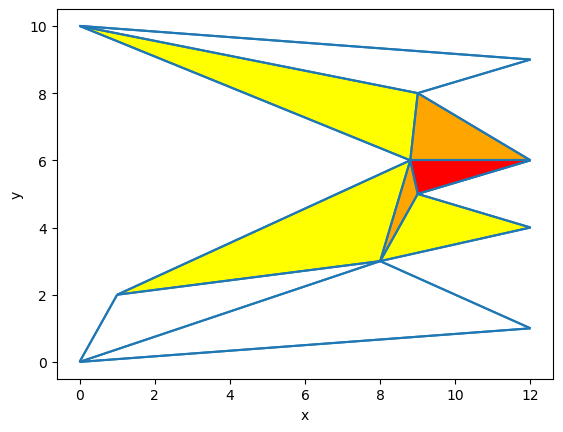

In [128]:
def are_triangles_incident(triangle1, triangle2):
    common_vertices = set(triangle1) & set(triangle2)
    return len(common_vertices) > 1


def find_triangle_neighbors(selected_triangle, triangles):
    neighbors_one_layer = set()
    neighbors_two_layers = set()

    
    for triangle in triangles:
        if selected_triangle != triangle and are_triangles_incident(selected_triangle, triangle):
            neighbors_one_layer.add(triangle)


    for neighbor_triangle in neighbors_one_layer:
        for triangle in triangles:
            if triangle != selected_triangle and triangle != neighbor_triangle and are_triangles_incident(neighbor_triangle, triangle):
                neighbors_two_layers.add(triangle)

    

    return list(neighbors_one_layer), list(neighbors_two_layers)


vertices = points4
triangles = triangulation4

selected_triangle = (5, 4, 9)
one_layer_neighbors, two_layers_neighbors = find_triangle_neighbors(selected_triangle, triangles)

vis = Visualizer()
vis.clear()
triangulation = triangles
points = vertices
polygon = convert_to_lines(points)
vis.add_line_segment(polygon)
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines)
current_triangle=[]
for point in selected_triangle:
    current_triangle.append(vertices[point])
vis.add_polygon(current_triangle,  color = "red")


for triangle in one_layer_neighbors:
    current_triangle=[]
    for point in triangle:
        current_triangle.append(vertices[point])
    vis.add_polygon(current_triangle,  color = "orange")


for triangle in two_layers_neighbors:
    current_triangle=[]
    for point in triangle:
        current_triangle.append(vertices[point])
    vis.add_polygon(current_triangle,  color = "yellow")

vis.show()

print("Otoczenie jednowarstwowe trójkąta", selected_triangle, "-", one_layer_neighbors)
print("Otoczenie dwuwarstwowe trójkąta", selected_triangle, "-", two_layers_neighbors)


# Przeszukiwanie incydentnych trójkątów by znaleźć ten zawierający wierzchołek, z użyciem prostej struktury

Trójkąt zawierający punkt 2 od trójkąta (6, 7, 8) - (4, 9, 2)


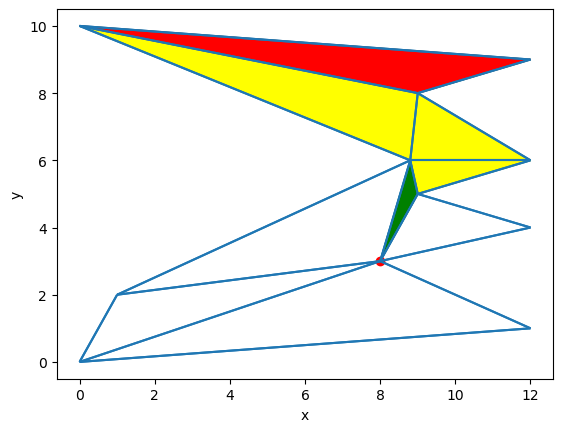

In [129]:
def are_triangles_incident(triangle1, triangle2):
    common_vertices = set(triangle1) & set(triangle2)
    return len(common_vertices) > 1


def find_triangle_containing_point(start_triangle, point, triangles):
    current_triangle = start_triangle
    visited_triangles = set()

    while current_triangle is not None:
        if current_triangle not in visited_triangles:
            visited_triangles.add(current_triangle)
            path_triangle=[]
            for current_point in list(current_triangle):
                path_triangle.append(vertices[current_point])
                vis.add_polygon(path_triangle,  color = "yellow")

            current_vertices = set(current_triangle)
            if point in current_vertices:
                return current_triangle

            incident_triangles = [triangle for triangle in triangles if are_triangles_incident(current_triangle, triangle)]
            
            unvisited_triangles = [triangle for triangle in incident_triangles if triangle not in visited_triangles]

            if unvisited_triangles:
                current_triangle = unvisited_triangles[0]
                
            else:
                break
        else:
            break

    return None

vertices = points4
triangles = triangulation4

start_triangle = (6, 7, 8)
target_point = 2



vis = Visualizer()
vis.clear()
triangulation = triangles
points = vertices
polygon = convert_to_lines(points)
vis.add_line_segment(polygon)
for triangle in triangulation:
    add = [points[triangle[0]], points[triangle[1]], points[triangle[2]]]
    lines = convert_to_lines(add)
    vis.add_line_segment(lines)


result_triangle = find_triangle_containing_point(start_triangle, target_point, triangles)

print("Trójkąt zawierający punkt", target_point, "od trójkąta", start_triangle, "-", result_triangle)


triangle=[]
for point in start_triangle:
    triangle.append(vertices[point])
vis.add_polygon(triangle,  color = "red")

triangle=[]
for point in result_triangle:
    triangle.append(vertices[point])
vis.add_polygon(triangle,  color = "green")

vis.add_point(vertices[target_point], color = "red")

vis.show()